<a href="https://colab.research.google.com/github/sotetsuk/pgx/blob/sotetsuk%2Fcolab%2Fc4-mcts/colab/mcts_connect_four.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Simple MCTS example with MCTX

Inspired by https://github.com/Carbon225/mctx-classic

In [1]:
!pip install pgx mctx

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 412.5/412.5 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.1/67.1 kB 7.2 MB/s eta 0:00:00


In [35]:
from typing import NamedTuple
from functools import partial

import jax
import jax.numpy as jnp
import chex
import mctx

import pgx
from pgx.experimental import act_randomly

from IPython.display import *

In [36]:
class Config(NamedTuple):
    env_id: pgx.EnvId = "connect_four"
    seed: int = 0
    num_simulations: int = 1_000
    batch_size: int = 1

config = Config()
env = pgx.make(config.env_id)

In [37]:
def policy_fn(legal_action_mask):
    """Return the logits of random policy. -Inf is set to illegal actions."""
    chex.assert_shape(legal_action_mask, (env.num_actions,))

    logits = legal_action_mask.astype(jnp.float32)
    logits = jnp.where(legal_action_mask, logits, jnp.finfo(logits.dtype).min)
    return logits


def value_fn(key, state):
    """Return the value based on random rollout."""
    chex.assert_rank(state.current_player, 0)

    def cond_fn(x):
        state, key = x
        return ~state.terminated

    def body_fn(x):
        state, key = x
        key, key_act, key_step = jax.random.split(key, 3)
        action = act_randomly(key_act, state.legal_action_mask)
        state = env.step(state, action, key_step)
        return (state, key)

    current_player = state.current_player
    state, _ = jax.lax.while_loop(cond_fn, body_fn, (state, key))
    return state.rewards[current_player]


def recurrent_fn(params, rng_key, action, state):
    del params
    current_player = state.current_player
    state = env.step(state, action)
    logits = policy_fn(state.legal_action_mask)
    value = value_fn(rng_key, state)
    reward = state.rewards[current_player]
    value = jax.lax.select(state.terminated, 0.0, value)
    discount = jax.lax.select(state.terminated, 0.0, -1.0)
    recurrent_fn_output = mctx.RecurrentFnOutput(
        reward=reward,
        discount=discount,
        prior_logits=logits,
        value=value,
    )
    return recurrent_fn_output, state


def run_mcts(key, state):
    key, subkey = jax.random.split(key)
    keys = jax.random.split(subkey, config.batch_size)
    key, subkey = jax.random.split(key)

    root = mctx.RootFnOutput(
        prior_logits=jax.vmap(policy_fn)(state.legal_action_mask),
        value=jax.vmap(value_fn)(keys, state),
        embedding=state
    )
    policy_output = mctx.muzero_policy(
        params=None,
        rng_key=subkey,
        root=root,
        invalid_actions=~state.legal_action_mask,
        recurrent_fn=jax.vmap(recurrent_fn, in_axes=(None, None, 0, 0)),
        num_simulations=config.num_simulations,
        max_depth=env.observation_shape[0] * env.observation_shape[1],  # 42 in connect four
        qtransform=partial(mctx.qtransform_by_min_max, min_value=-1, max_value=1),
        dirichlet_fraction=0.0
    )
    return policy_output

In [38]:
def vs_human(is_human_first = True):
    assert config.batch_size == 1
    key = jax.random.PRNGKey(config.seed)
    init_fn = jax.jit(jax.vmap(env.init))
    step_fn = jax.jit(jax.vmap(env.step))

    key, subkey = jax.random.split(key)
    keys = jax.random.split(subkey, config.batch_size)
    state: pgx.State = init_fn(keys)

    is_human_turn = is_human_first
    while True:
        clear_output(True)
        pgx.save_svg(state, "/tmp/state.svg")
        display_svg(SVG("/tmp/state.svg"))
        if state.terminated.all():
            break
        if is_human_turn:
            action = int(input("Your action: "))
            action = jnp.int32([action])
        else:
            policy_output = jax.jit(run_mcts)(key, state)
            action = policy_output.action
        state = step_fn(state, action)
        is_human_turn = not is_human_turn

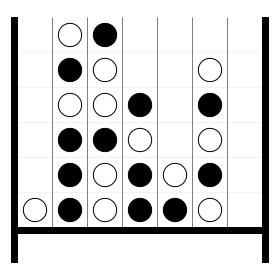

In [39]:
vs_human()